In [227]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [228]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../data/data-cluster-examples-pause"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    # if "fallingDrop" not in directory:
    #     print(f"Skipping {directory}")
    #     continue

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        # assert len(corresponding_liveInfo) == len(
        #     tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # convert tuningData timings into percentages
        maxTime = tuningData["Reduced"].max()
        tuningData.insert(1, "PerformancePercentage", (
            tuningData["Reduced"] / maxTime) * 100)

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

Processing ../../data/data-cluster-examples-pause/uniformCube_b_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_1
Processing ../../data/data-cluster-examples-pause/fallingDrop_2
Processing ../../data/data-cluster-examples-pause/uniformCube_b_1
Processing ../../data/data-cluster-examples-pause/fallingDrop_1


In [229]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(152194, 29)

In [230]:
df.describe()

avgParticlesPerCell         cutoff    domainSizeX    domainSizeY  \
count        152194.000000  152194.000000  152194.000000  152194.000000   
mean              1.002378       2.999691      78.857502      68.725696   
std               0.694563       0.012422      21.146944      14.849524   
min               0.905797       2.500000      49.561231      29.561231   
25%               0.905797       3.000000      50.000000      50.000000   
50%               0.905797       3.000000      93.750000      78.750000   
75%               0.944637       3.000000      93.750000      78.750000   
max               6.829864       3.000000     240.000000     240.000000   

         domainSizeZ  estimatedNumNeighborInteractions    homogeneity  \
count  152194.000000                      1.521940e+05  152194.000000   
mean       62.261861                      1.672515e+05       0.059424   
std        10.255107                      1.233248e+06       0.046082   
min        37.296003                      6.000200e+04       0.033138   
25%        50.000000                      8.303600e+04       0.036179   
50%        68.750000                      1.458290e+05       0.044863   
75%        68.750000                      1.527630e+05       0.080661   
max       240.000000                      4.966793e+07       0.430119   

          maxDensity  maxParticlesPerCell  minParticlesPerCell  ...  \
count  152194.000000        152194.000000        152194.000000  ...   
mean        0.471405            20.685664             0.000618  ...   
std         0.196954             4.650628             0.024845  ...   
min         0.095751             8.000000             0.000000  ...   
25%         0.336900            19.000000             0.000000  ...   
50%         0.457475            22.000000             0.000000  ...   
75%         0.572880            23.000000             0.000000  ...   
max         1.602795            44.000000             1.000000  ...   

       particleSizeNeededByFunctor  particlesPerBlurredCellStdDev  \
count                     152194.0                  152194.000000   
mean                          72.0                       0.188950   
std                            0.0                       0.116240   
min                           72.0                       0.016345   
25%                           72.0                       0.054497   
50%                           72.0                       0.201113   
75%                           72.0                       0.292530   
max                           72.0                       0.398774   

       particlesPerCellStdDev  rebuildFrequency           skin    threadCount  \
count           152194.000000          152194.0  152194.000000  152194.000000   
mean                 0.022383              10.0       0.999691      13.788901   
std                  0.012943               0.0       0.012422      10.666275   
min                  0.000594              10.0       0.500000       1.000000   
25%                  0.013048              10.0       1.000000       4.000000   
50%                  0.013655              10.0       1.000000      12.000000   
75%                  0.039968              10.0       1.000000      24.000000   
max                  0.047267              10.0       1.000000      28.000000   

       PerformancePercentage  CellSizeFactor       Reduced      Smoothed  
count          152194.000000        152194.0  1.521940e+05  1.521940e+05  
mean               38.638200             1.0  2.184659e+07  2.156555e+07  
std                14.362951             0.0  1.586187e+08  1.586149e+08  
min                 0.140350             1.0  3.069750e+06  3.069750e+06  
25%                28.635337             1.0  1.095089e+07  1.081780e+07  
50%                36.098562             1.0  1.677061e+07  1.645878e+07  
75%                47.686853             1.0  2.285388e+07  2.244845e+07  
max               100.000000             1.0  1.100861e+10  1.100861e+10  

[8 ro

In [231]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Define Interesting Data to observe


In [232]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    # "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [233]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'PerformancePercentage', 'CellSizeFactor', 'Traversal',
       'Load Estimator', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Filter Data / Outliers


In [234]:
# only keep rows where performance percentage is above x
dffiltered = df[df["PerformancePercentage"] >= 70]


def combine_columns(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# group data on input columns and concatenate output columns
dfgrouped = dffiltered.groupby(inputs).agg(combine_columns).reset_index()

# remove columns that are not needed
dfgrouped.drop(columns=["Reduced", "Smoothed",
               "PerformancePercentage"], inplace=True)

# remove outliers
standard_deviations = 3
dfgrouped = dfgrouped[dfgrouped.apply(lambda x: type(x[0]) == str or
                                      np.abs(x - x.mean()) / x.std() < standard_deviations)
                      .all(axis=1)]

# filter values occuring less than pct
pct = 0.01
for column in outputs:
    counts = dfgrouped[column].value_counts()
    dfgrouped = dfgrouped[dfgrouped[column].isin(
        counts[counts > len(dfgrouped) * pct].index)]


X, y = dfgrouped[inputs], dfgrouped[outputs]
print(X.shape, y.shape)

(1327, 5) (1327, 3)


# Create Train and Test Data


In [235]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [236]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  particlesPerCellStdDev  \
448              0.905797     0.048403    0.304984                0.014257   
173              0.905797     0.037069    0.414919                0.013218   
1015             0.944637     0.082259    0.710520                0.039478   
1082             0.944637     0.082699    0.732840                0.040227   
217              0.905797     0.040693    0.425558                0.013396   

      threadCount                     Container_DataLayout  \
448             4  LinkedCells_AoS, VerletClusterLists_AoS   
173            24                          LinkedCells_SoA   
1015           12                   VerletClusterLists_AoS   
1082           24                   VerletClusterLists_AoS   
217             4                   VerletClusterLists_AoS   

                                              Traversal  Newton 3  
448   lc_c01, vcl_c01_balanced, vcl_c06, vcl_cluster...  disabled  
173                                              lc_c18  disabled  
1015                                            vcl_c06  disabled  
1082                          vcl_c01_balanced, vcl_c06  disabled  
217                                    vcl_c01_balanced  disabled

In [237]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

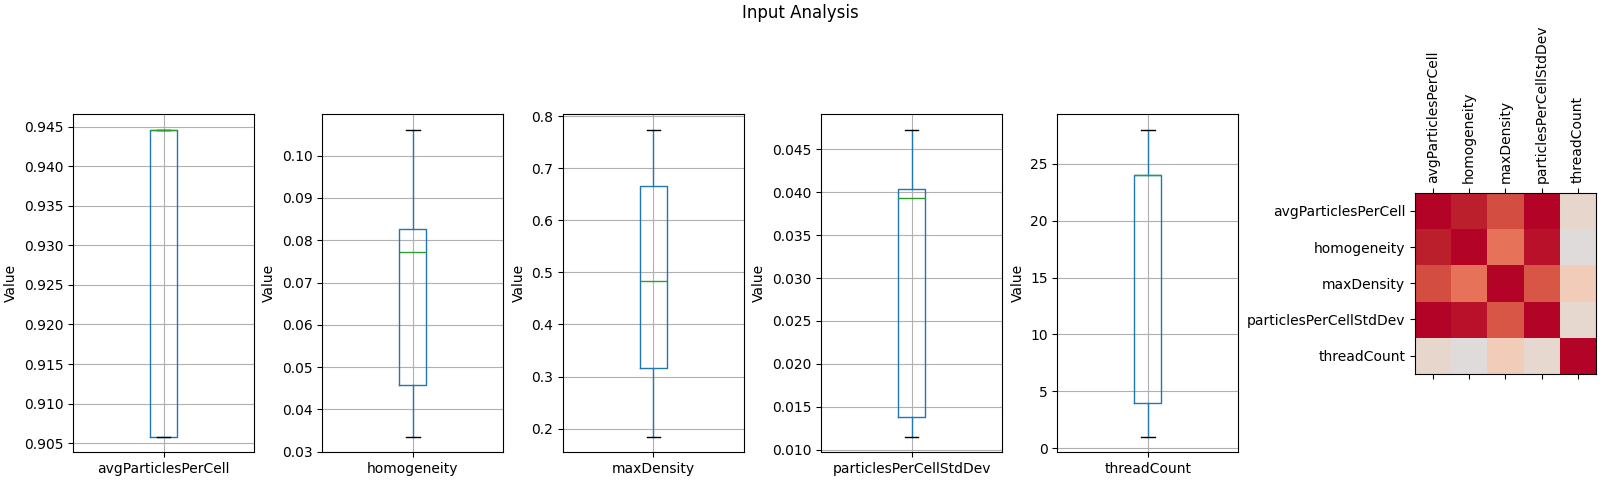

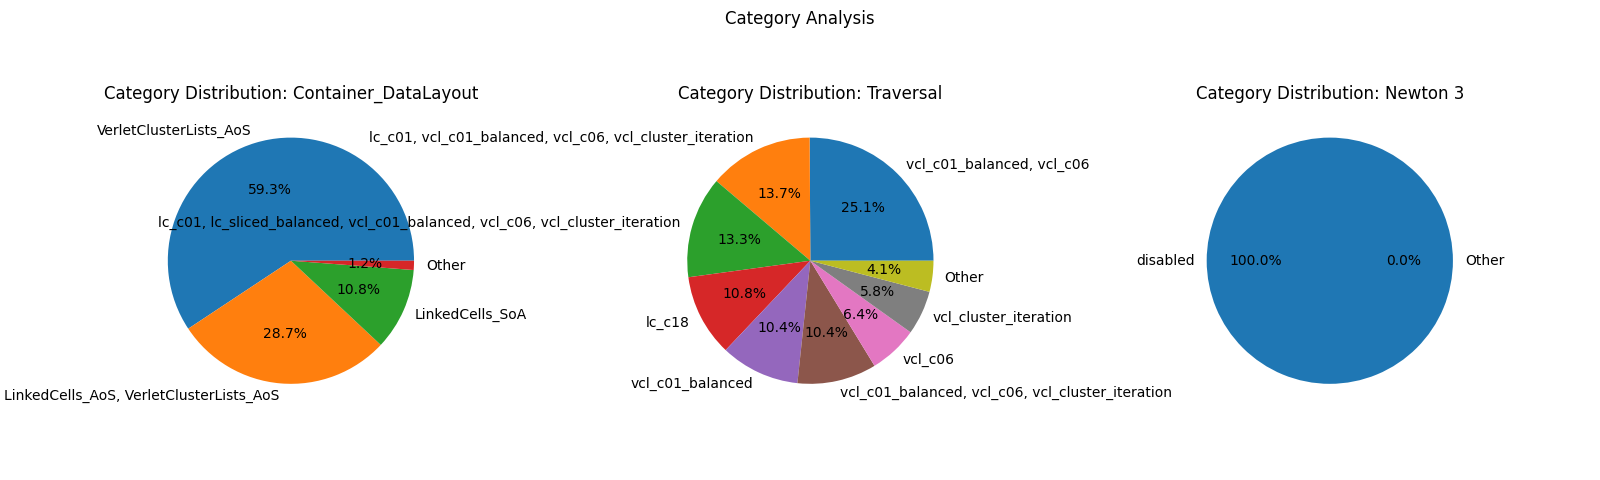

In [238]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [239]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.03,
    "Traversal": 0.05,
    "Newton 3": 0.05,

}

# maximum depth of the decision tree
MAX_DEPTH = 10

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 3

Training on 1061 samples
Number of rules 44:
	Container_DataLayout (12 rules)
	Traversal (31 rules)
	Newton 3 (1 rules)


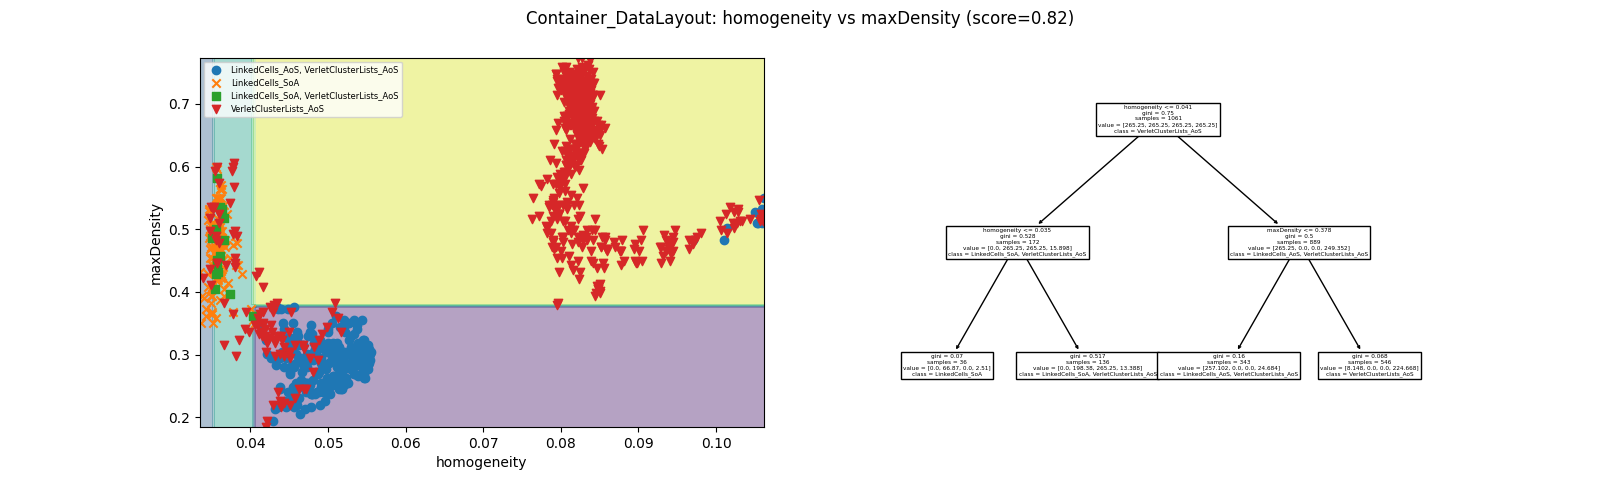

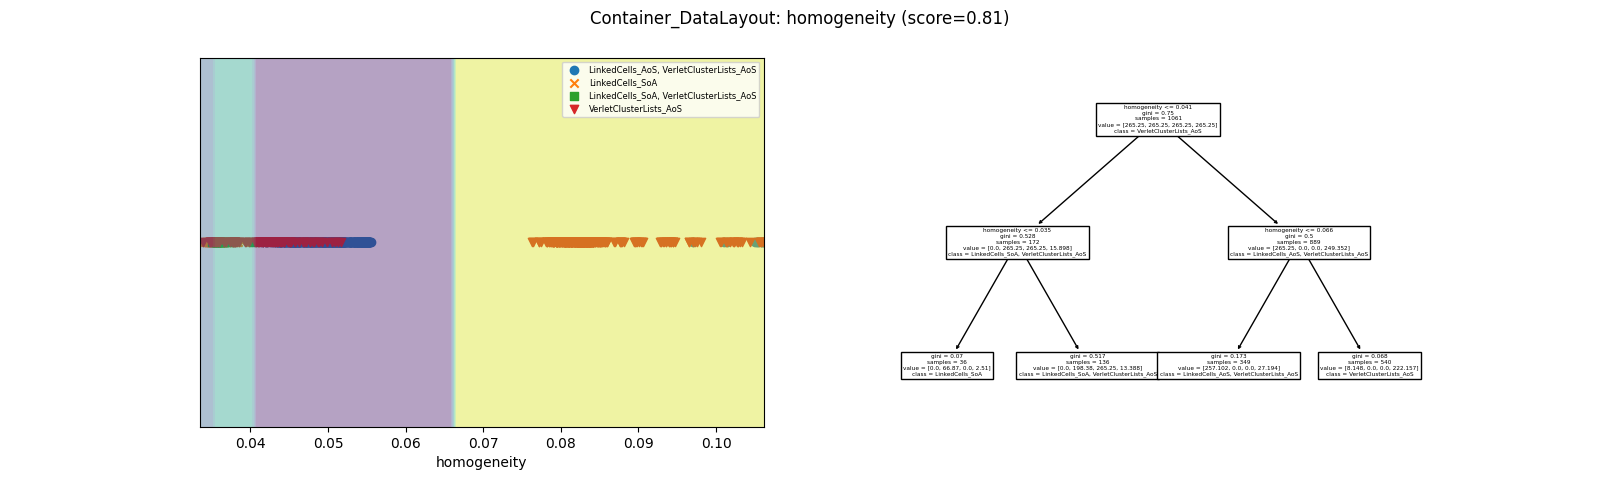

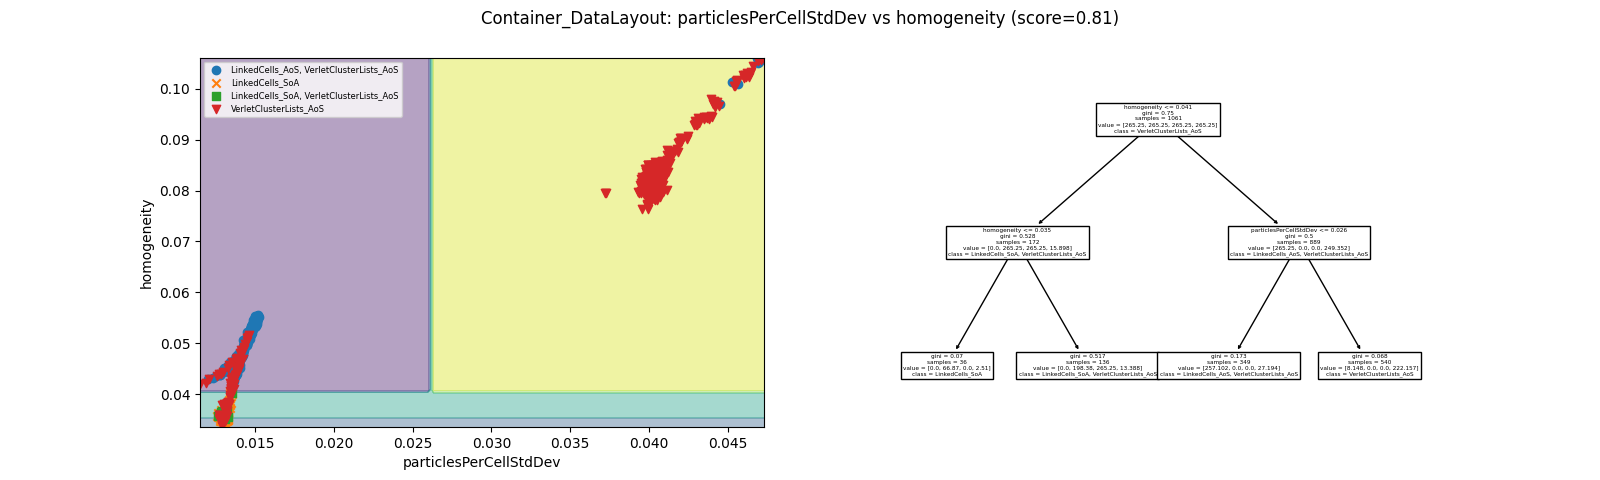

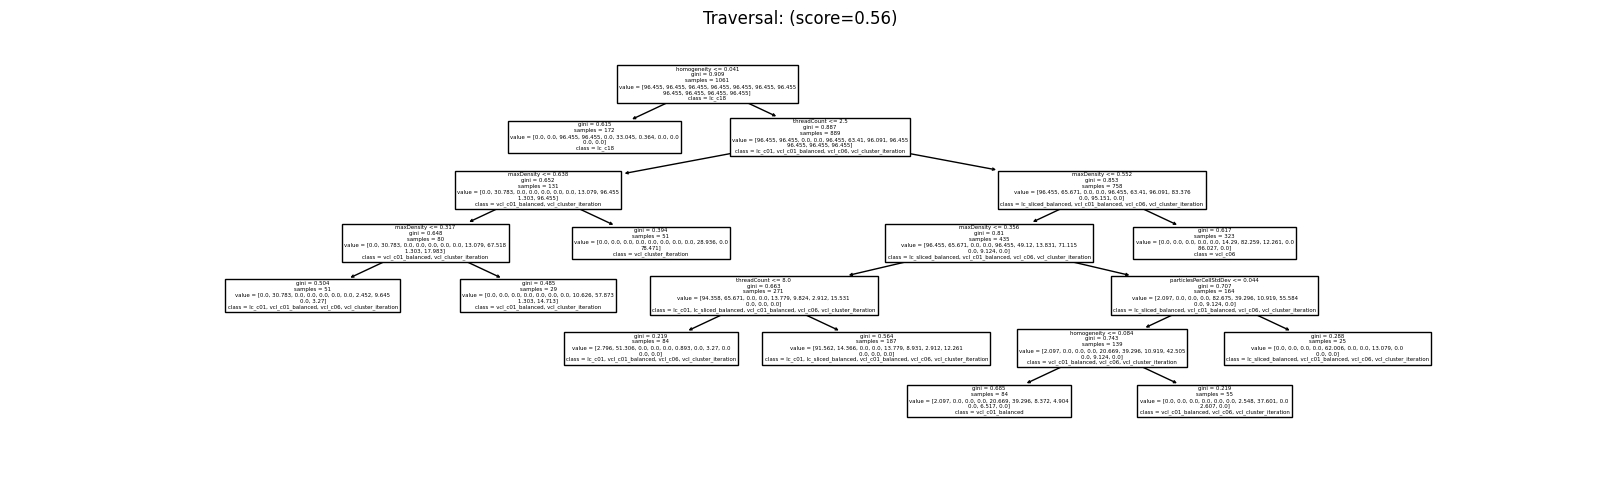

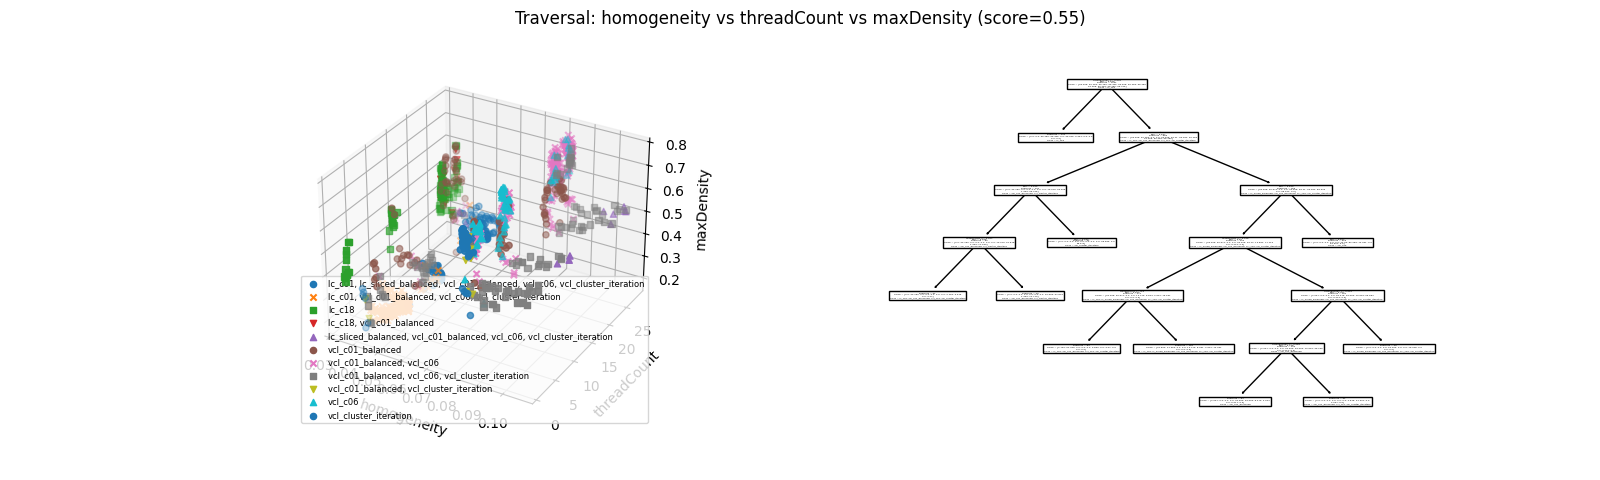

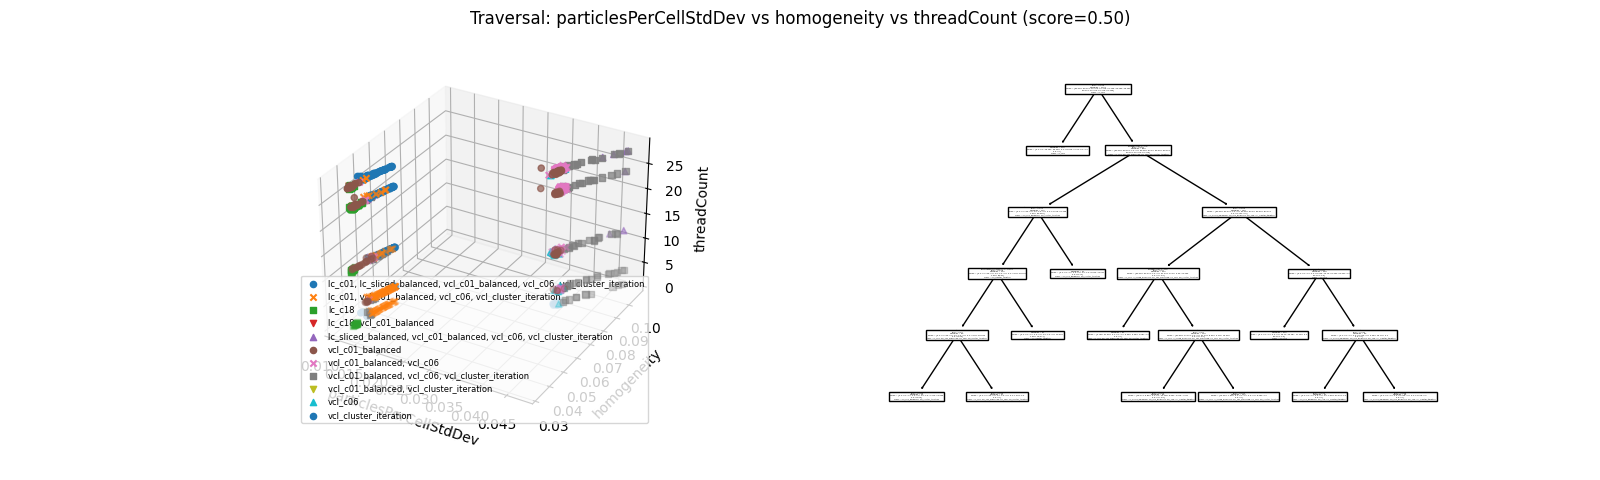

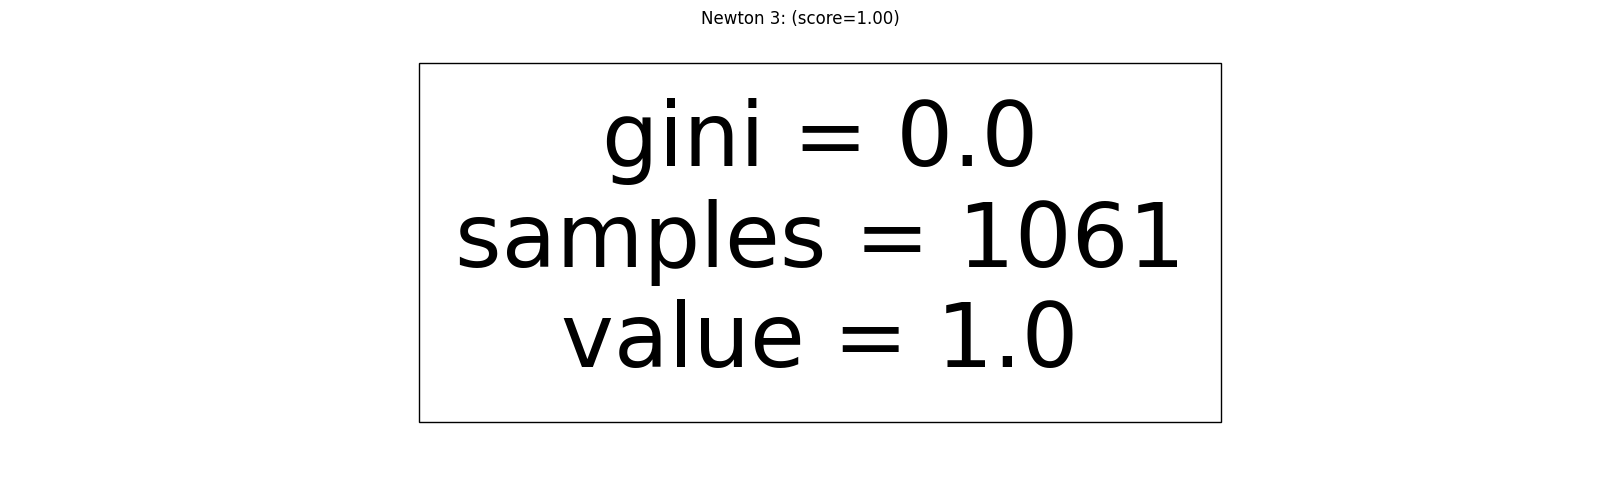

In [240]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

homogeneity: [-inf, 0.035, 0.041, 0.044, 0.047, 0.066, 0.084, 0.085, 0.097, inf]
homogeneity: [-inf, 0.035, 0.041, 0.044, 0.047, 0.066, 0.084, 0.097, inf]

maxDensity: [-inf, 0.317, 0.356, 0.378, 0.552, 0.638, inf]
maxDensity: [-inf, 0.317, 0.356, 0.378, 0.552, 0.638, inf]

particlesPerCellStdDev: [-inf, 0.026, 0.027, 0.041, 0.044, inf]
particlesPerCellStdDev: [-inf, 0.026, 0.041, 0.044, inf]

threadCount: [-inf, 2.5, 8.0, inf]
threadCount: [-inf, 2.5, 8.0, inf]



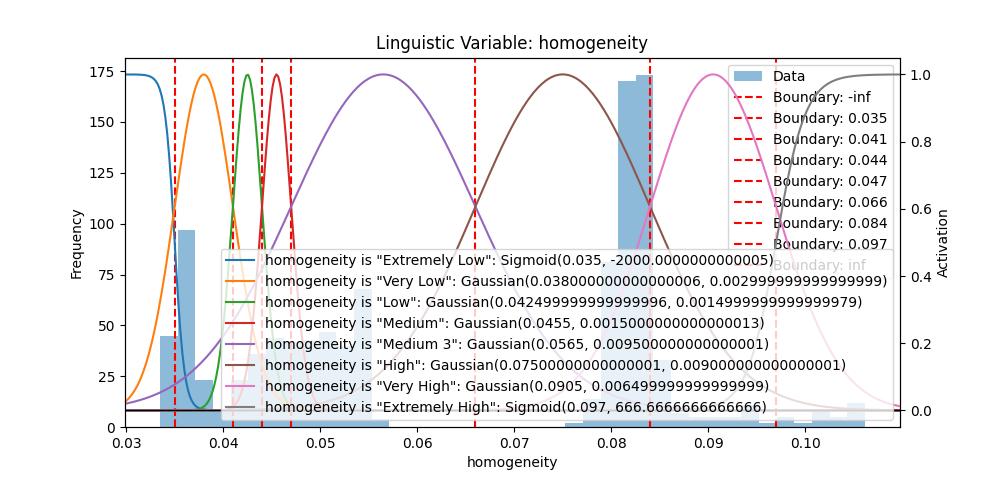

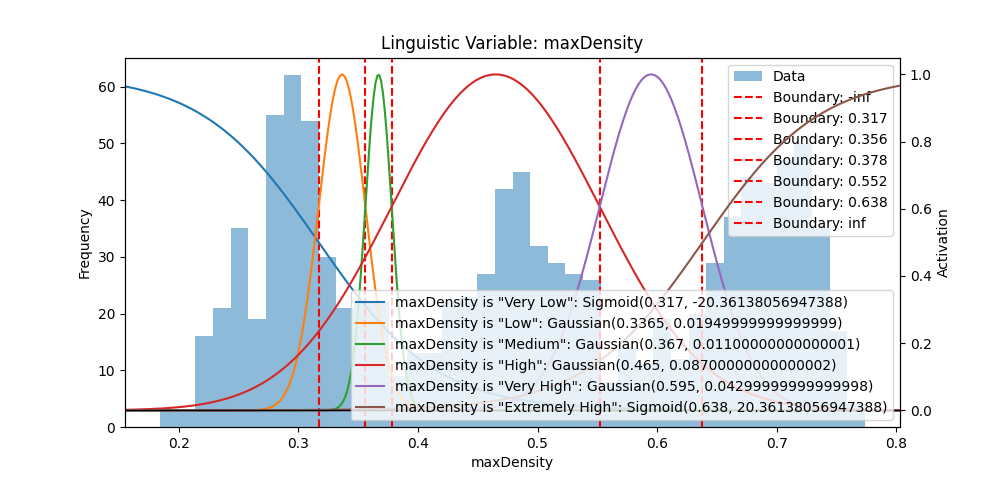

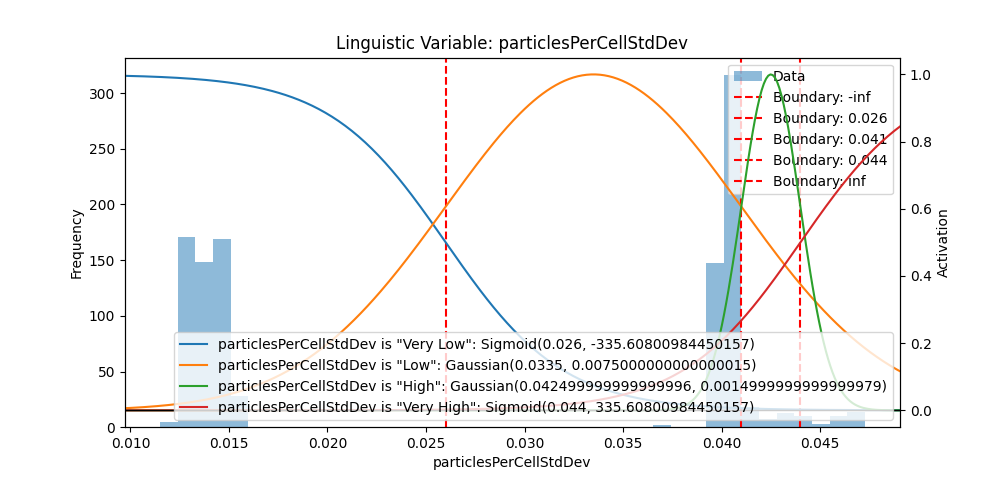

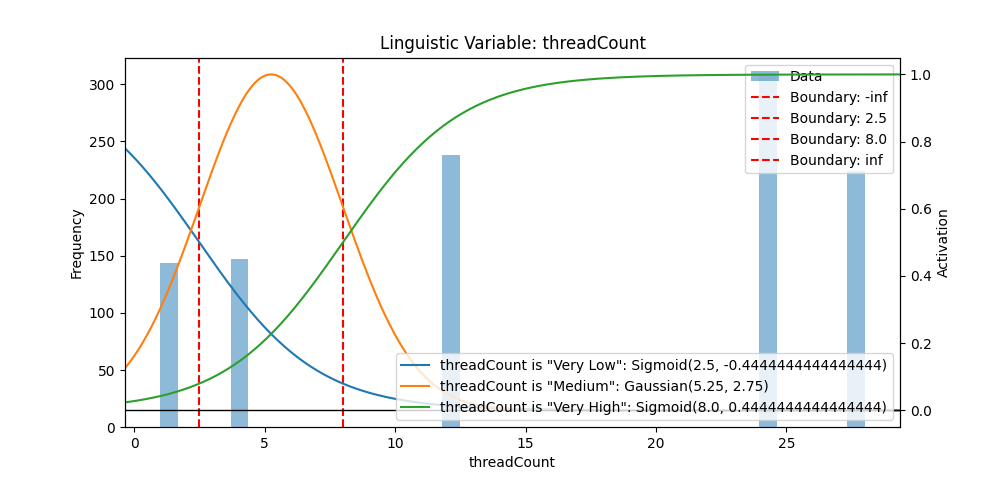

In [241]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


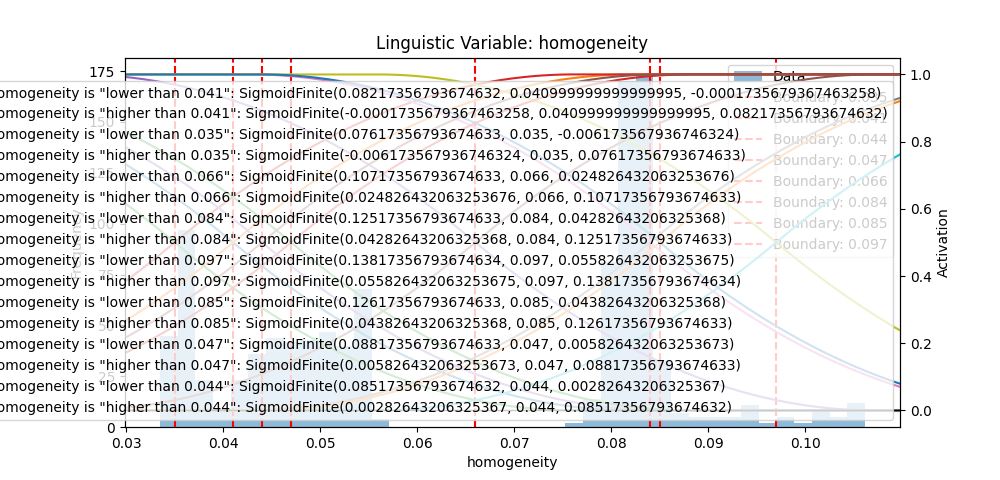

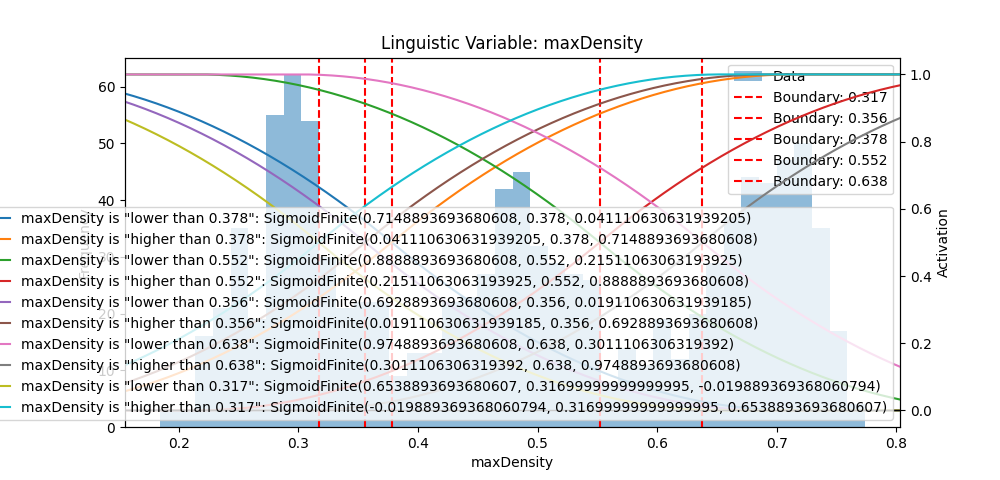

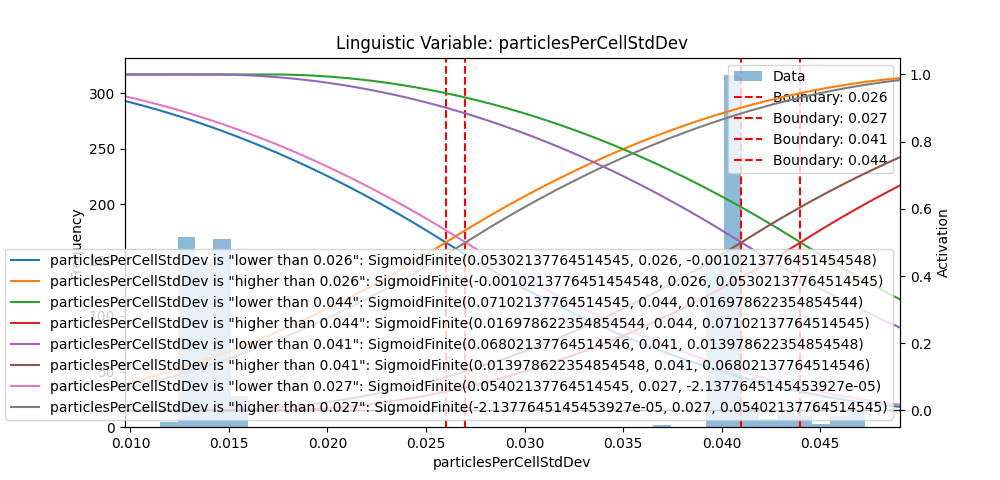

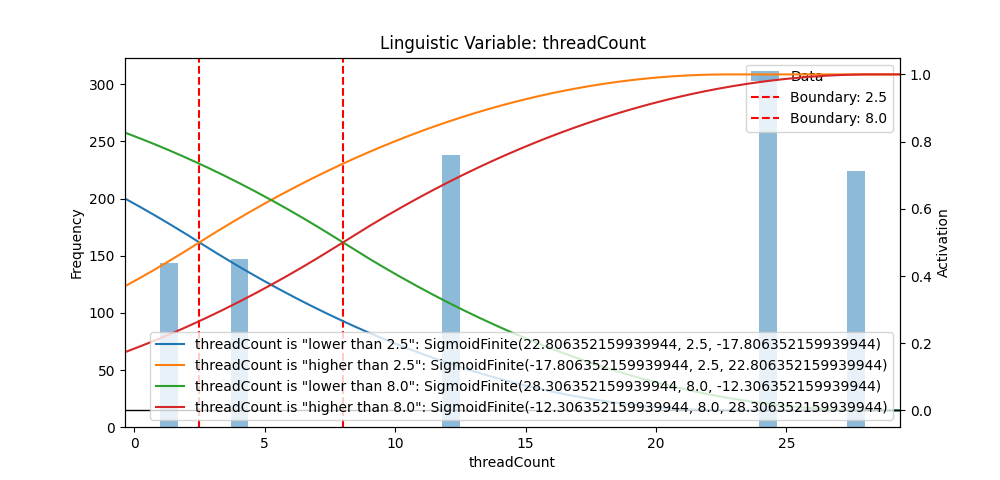

In [242]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/../demo/fuzzy-test/python/fuzzy_system.py:380: RuntimeWarning: invalid value encountered in scalar divide
  def function(x): return np.exp(-0.5 * ((x - mean) / sigma) ** 2)
/home/manuel/AutoPas-FuzzyTuning-Bachelor-Thesis/data-analysis/cluster-examples-pause/../rule_extraction.py:537: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(min(inputs), max(inputs))


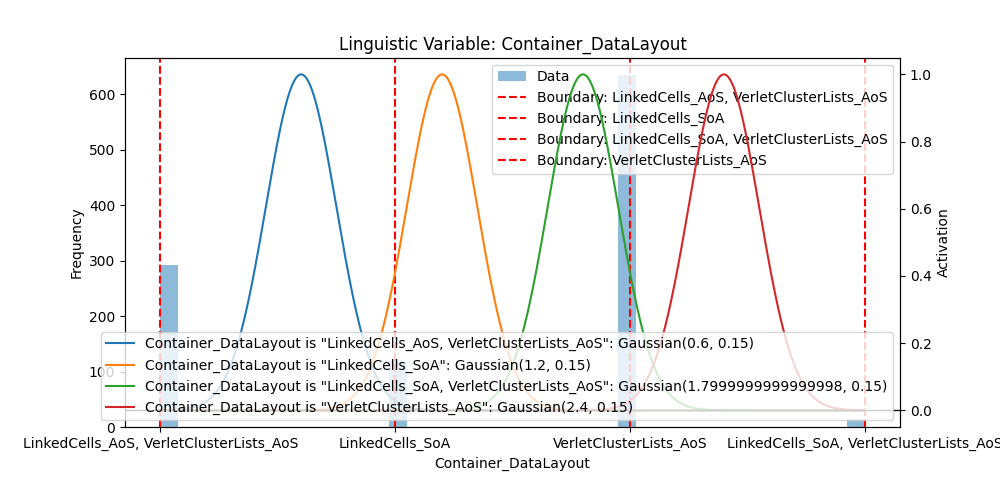

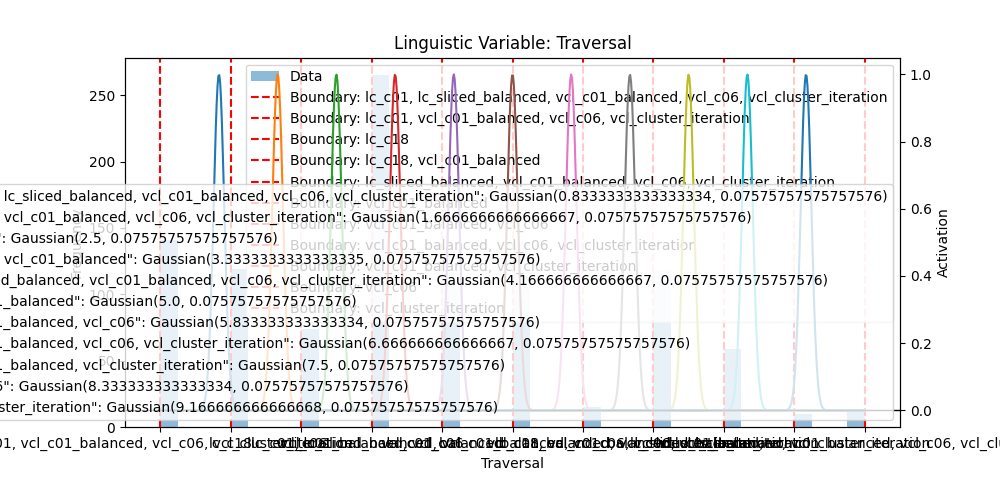

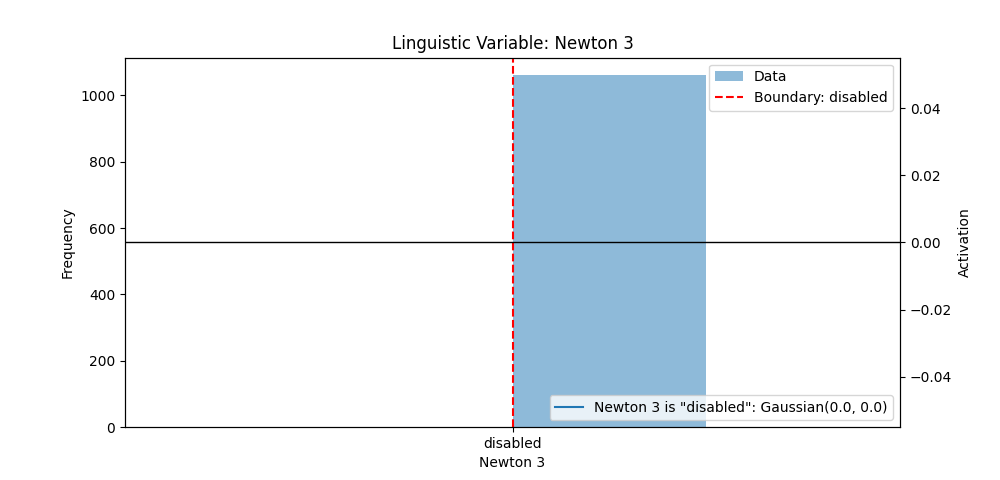

In [243]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [244]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "homogeneity" range: (-0.00766456793674633, 0.14730856793674632)
	"Extremely Low": Sigmoid(0.035, -2000.0000000000005)
	"Very Low": Gaussian(0.038000000000000006, 0.002999999999999999)
	"Low": Gaussian(0.042499999999999996, 0.0014999999999999979)
	"Medium": Gaussian(0.0455, 0.0015000000000000013)
	"Medium 3": Gaussian(0.0565, 0.009500000000000001)
	"High": Gaussian(0.07500000000000001, 0.009000000000000001)
	"Very High": Gaussian(0.0905, 0.006499999999999999)
	"Extremely High": Sigmoid(0.097, 666.6666666666666)

FuzzyVariable: domain: "maxDensity" range: (-0.1524803693680608, 1.1106493693680608)
	"Very Low": Sigmoid(0.317, -20.36138056947388)
	"Low": Gaussian(0.3365, 0.01949999999999999)
	"Medium": Gaussian(0.367, 0.01100000000000001)
	"High": Gaussian(0.465, 0.08700000000000002)
	"Very High": Gaussian(0.595, 0.04299999999999998)
	"Extremely High": Sigmoid(0.638, 20.36138056947388)

FuzzyVariable: domain: "particlesPerCellStdDev" range: (-0.015510377645145453, 0.